In [2]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
os.chdir('..')
from matplotlib import pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms, get_rms_no_outliers

In [5]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class Readout(torch.nn.Linear):
    def __init__(self, args, data):
        super().__init__(args.HIDDEN_DIM, len(data.output_map))

    def forward(self, x):
        return super().forward(x[:, -1, :])


class Transformer(TransformerEncoder):
    def __init__(self, args, data):
        layer = TransformerEncoderLayer(args.HIDDEN_DIM, 1, args.HIDDEN_DIM, dropout=0)
        super().__init__(layer, args.DEPTH)
        self.emb = torch.nn.ParameterList(
            [
                torch.nn.Parameter(torch.randn(size, args.HIDDEN_DIM))
                for size in data.vocab_size
            ]
        )
        self.readout = Readout(args, data)

    def forward(self, x):
        x = [emb[x[:, i]] for i, emb in enumerate(self.emb)]
        x = torch.stack(x, dim=1)
        x = super().forward(x)
        return self.readout(x)


def get_model_and_optim(data, args):
    model = Transformer(args, data).to(args.DEV)
    optim = torch.optim.Adam(model.parameters(), lr=args.LR)
    return model, optim


def inverse_transform(tensor, data):
    min_ = torch.from_numpy(data.regression_transformer.data_min_).to(tensor.device)
    max_ = torch.from_numpy(data.regression_transformer.data_max_).to(tensor.device)
    return (tensor * (max_ - min_) + min_).float()

In [6]:
task = "binding"
experiment_name = f"transformer/{task}"
os.makedirs("experiments", exist_ok=True)
os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
args = {
    "DEPTH": 2,
    "DEV": (device:="cuda"),
    "EPOCHS": 20_000,
    "HIDDEN_DIM": 2048,
    "LR": 0.01,
    "MODEL": "baseline",
    "SIGMOID_READOUT": "false",
    "TMS": "remove",
    "WD": 0.01,
    "DEV": "cuda",
    "TARGETS_CLASSIFICATION": {},
    "TARGETS_REGRESSION": {f"{task}": 100},
    "TRAIN_FRAC": 1,
    "LIPSCHITZ": "false",
    "TRAIN_SET": "all_data", # random, all_data, extrap_1, extrap_2, extrap_3
    "BATCH_SIZE": 1024,
    "LOG_TIMES": 10,
    "NUCLEI_GE": 0,
    "NUCLEI_HIGH_UNC": "keep",
    "PER_NUCLEON": "true",
    "SEED": 0,
}

args = Namespace(**args)

# IO.save_args(args, f"experiments/{experiment_name}/args.yaml")

data = prepare_nuclear_data(args)


# setup training data
X_train = data.X[data.train_mask]
y_train = data.y[data.train_mask]
non_nan_targets = ~torch.isnan(y_train.view(-1))
X_train = X_train[non_nan_targets]
y_train = y_train[non_nan_targets]

def quick_eval(model, task="binding", verbose=True, train=False):
    """helper to get the rms for the franken model"""
    preds, targets, zn = preds_targets_zn(data, model, task, train=train)
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    rms_clip = get_rms_no_outliers(preds, targets, zn, scale_by_A=args.PER_NUCLEON=="true")
    if verbose:
        print(f"RMS for franken model: {rms:.2f}")
        print(f"RMS for franken model (clipped): {rms_clip:.2f}")
    return rms, rms_clip

torch.manual_seed(1)
new_model, optim_model = get_model_and_optim(data, args)


  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 0: 14101070.00
Train RMS binding: 27076594.96 (26729734.90) Epoch 2000: 152940192.00
Train RMS binding: 2557711.65 (2529005.83) Epoch 4000: 437422.50
Train RMS binding: 61671.74 (57033.32) Epoch 6000: 473857.59
Train RMS binding: 93290.99 (87504.31) Epoch 8000: 437422.47
Train RMS binding: 61671.80 (57033.37) Epoch 10000: 437422.47
Train RMS binding: 61672.00 (57033.55) Epoch 12000: 437760.47
Train RMS binding: 61163.44 (56585.51) Epoch 14000: 437422.75
Train RMS binding: 61711.38 (57068.46) Epoch 16000: 437422.47
Train RMS binding: 61672.12 (57033.66) Epoch 18000: 437422.47
Train RMS binding: 61671.68 (57033.27) 

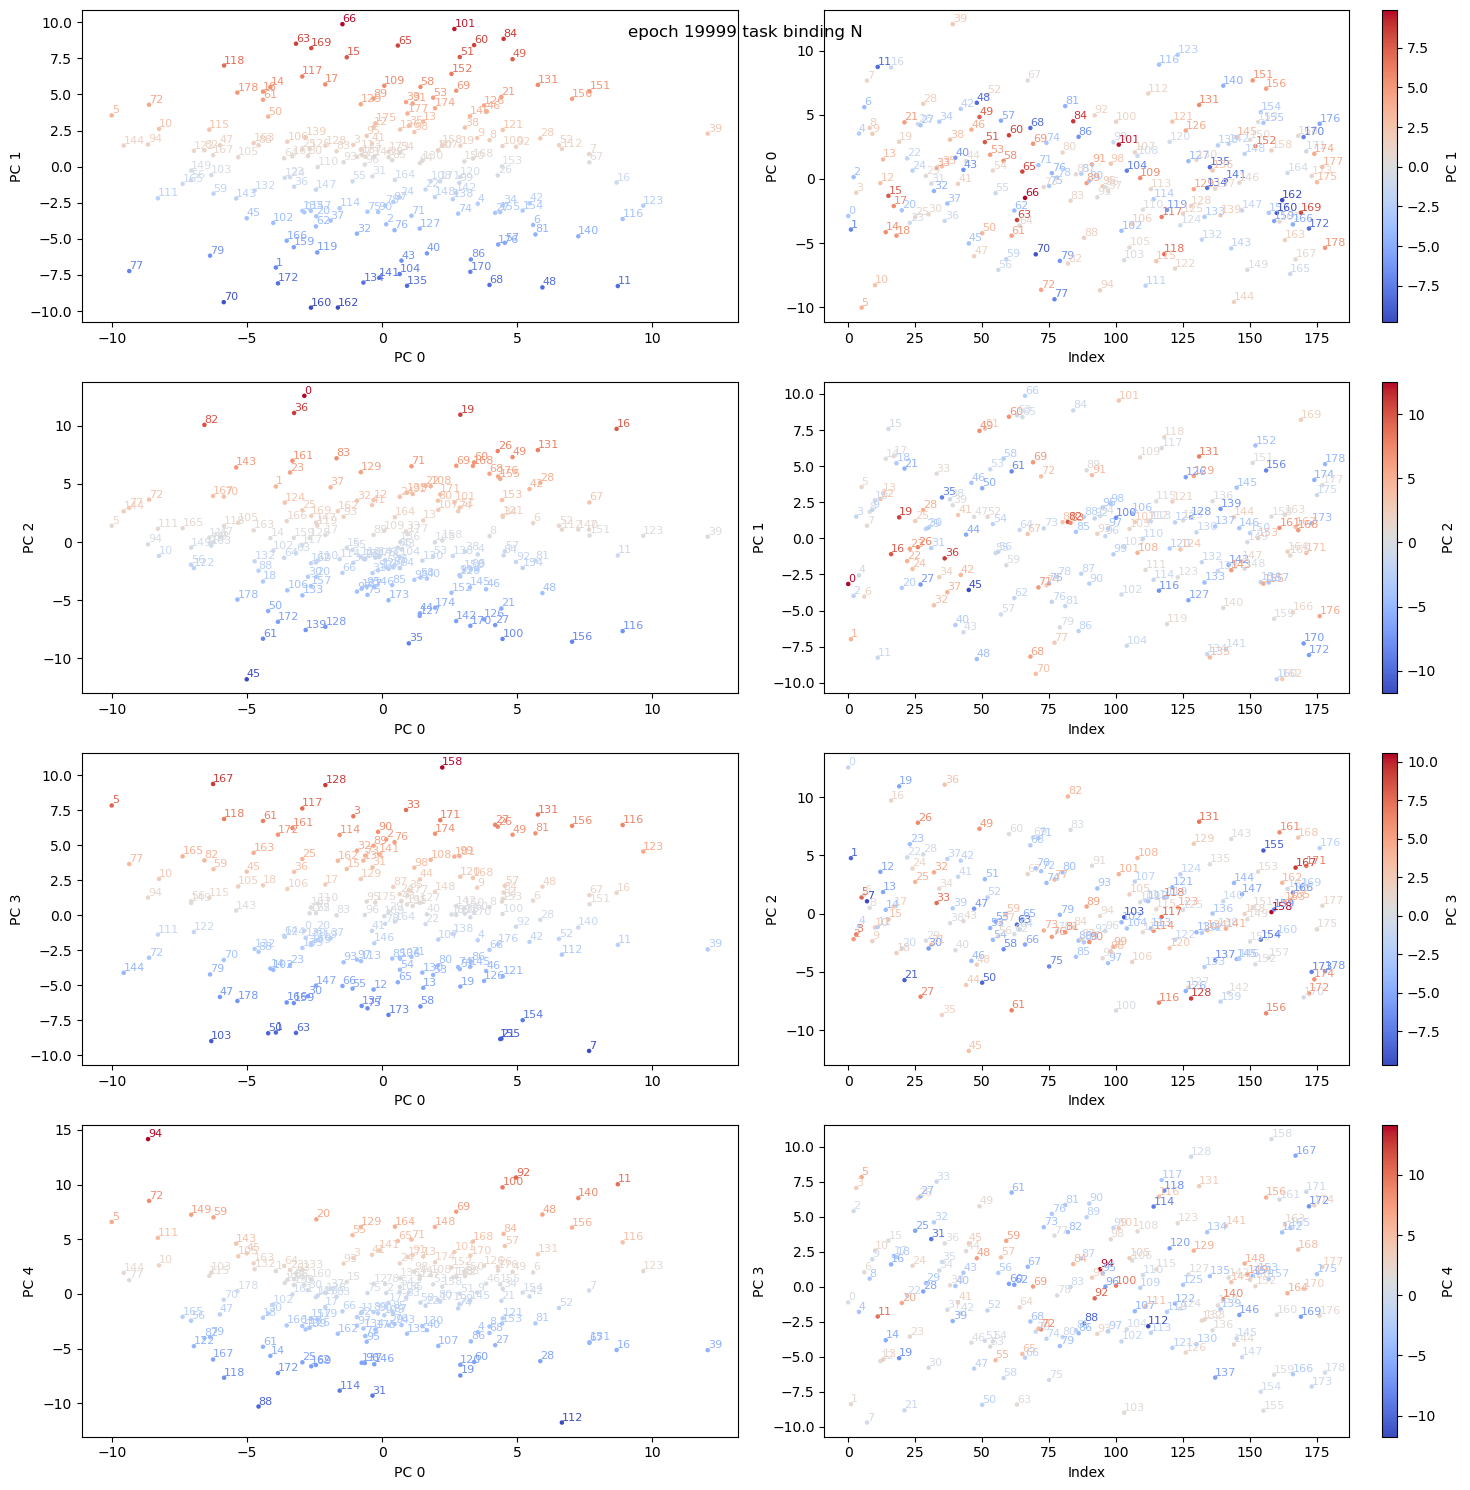

In [7]:
#train the new model

epochs = args.EPOCHS
task_name = list(data.output_map.keys())[0]
for epoch in (pbar:=tqdm(range(epochs))):
    optim_model.zero_grad()
    preds = new_model(X_train)
    preds = inverse_transform(preds, data)
    preds = preds.gather(1, X_train[:, 2].long().view(-1, 1))
    loss = torch.nn.functional.mse_loss(preds, y_train)
    loss.backward()
    optim_model.step()
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch}: {loss.item():.2f}")
        train_rms = quick_eval(new_model, task_name, verbose=False, train=True)
        # val_rms = quick_eval(new_model, "binding", verbose=False, train=False)
        print(f"Train RMS {task_name}: {train_rms[0]:.2f} ({train_rms[1]:.2f})", end=" ")
        # print(f"Val RMS: {val_rms[0]:.2f} ({val_rms[1]:.2f})")
        embed = new_model.emb[1].detach().cpu().numpy()
        # PlottingContext.plot_embedding(embed, num_components=3); plt.show()
    pbar.set_description(f"Epoch {epoch}: {loss.item():.2e}")

# let's take a look at our embeddings
nucleons = "ZN" 
embed = new_model.emb[(nucleon:=1)].detach().cpu().numpy()
fig = PlottingContext.plot_embedding(embed, num_components=5)
fig.suptitle(f"epoch {epoch} task {task_name} {nucleons[nucleon]}")
# fig.savefig(f"experiments/{experiment_name}/embedding.png", dpi=300)
fig.show()

In [1]:
preds

NameError: name 'preds' is not defined